In [1]:
from predict import *
import librosa

f_name = 'data/LibriTTS/dev-other/3660/172182/3660_172182_000017_000006'
audio_data, _ = librosa.load(f'{f_name}.wav')
with open(f'{f_name}.normalized.txt', 'r') as f:
    text = f.read()
print(text)

/home/overlord/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then they set forth towards the court of Arthur.


In [2]:
audio_mels = melspec(audio_data)
audio_input = torch.tensor(audio_mels).unsqueeze(0)
sp_embeddings = sp_encoder(audio_input)

text_input = torch.tensor(text_ordinal(text)).unsqueeze(0)
output_mels = synthesizer(text_input, sp_embeddings)

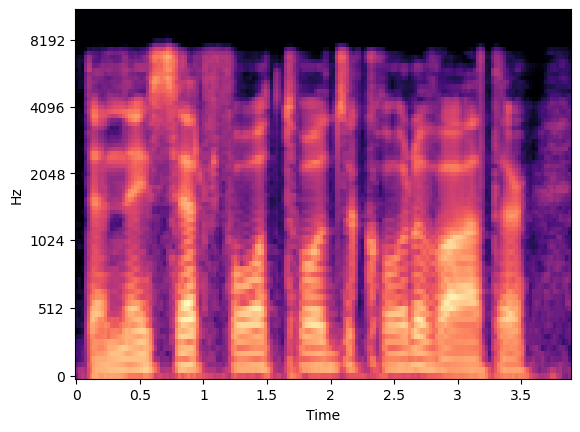

In [3]:
import matplotlib.pylab as plt
import numpy as np

def plot_data(data):
    db_data = librosa.power_to_db(data, ref=np.max)
    librosa.display.specshow(db_data, sr=22050, x_axis='time', y_axis='mel')

audio_pred = output_mels.squeeze(0).numpy()#[0:audio_mels.shape[0]]

plot_data(audio_mels.T)

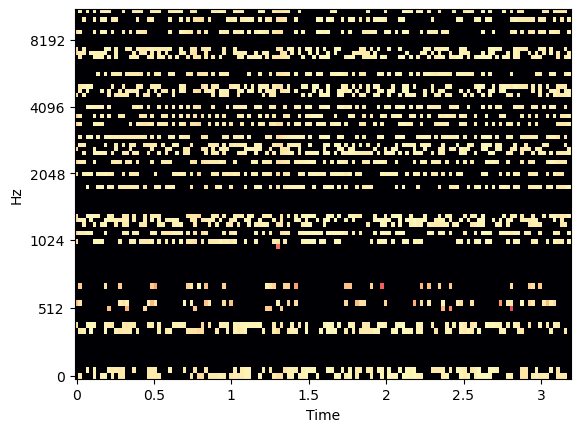

In [68]:
from torch import nn
from torch.nn import functional as F

with torch.no_grad():
    x = synthesizer.character_embedding(text_input.int())
    x = x.transpose(1, 2)
    for conv in synthesizer.conv_layers:
        x = F.relu(conv(x))
        #x = F.dropout(x, p=0.5, training=True)
    x = x.transpose(1, 2)
    x, _ = synthesizer.bidirectional_lstm(x)
    text_embedding = synthesizer._cat_with_voiceprint(x, sp_embeddings)
    prediction_frames = torch.tensor([])
    stop_token = 0.0
    training_values = synthesizer._get_init_training_values(text_embedding)
    input_frame = torch.zeros(text_embedding.shape[0], 1, synthesizer.n_mels)
    prediction_frames = torch.tensor([])

    while stop_token < 0.5 and (prediction_frames.shape[0] == 0 or prediction_frames.shape[1] < 5000):
        prenet_embeds = synthesizer.prenet(input_frame)
        decoder_output, training_values = synthesizer.decode_frame(prenet_embeds.squeeze(1), text_embedding, training_values)
        attention_context = training_values[0]
        stop_token_prediction, mel_act, mel_resid = synthesizer.predict_frame(decoder_output, attention_context) 
        stop_token = stop_token_prediction.item()
        #input_frame = (mel_resid.transpose(1,2) + mel_act.unsqueeze(0)) / 2.
        input_frame = mel_act.unsqueeze(0)
        #input_frame = mel_resid.transpose(1, 2)
        prediction_frames = torch.cat((prediction_frames, input_frame + mel_resid.transpose(1, 2)), dim=1)
    
    plot_data(prediction_frames.unsqueeze(0).T)

In [79]:
prediction_frames[:, 0, :], audio_mels[0]

(tensor([[ 0.0000,  0.0000, -0.0610, -0.0000, -0.0396, -0.0450, -0.0573, -0.0000,
           0.0000,  0.0535, -0.0000, -0.0000, -0.0373,  0.0141, -0.0494, -0.0000,
          -0.0419, -0.0000, -0.0500, -0.0560, -0.0000, -0.0495, -0.0505, -0.0000,
           0.0664, -0.0000,  0.0569, -0.0000,  0.0000,  0.0619,  0.0547, -0.0000,
          -0.0585, -0.0616, -0.0562, -0.0473, -0.0560,  0.0000, -0.0000, -0.0000,
           0.0573, -0.0000, -0.0000,  0.0504, -0.0583,  0.0000,  0.0516,  0.0000,
          -0.0545,  0.0000, -0.0527, -0.0510,  0.0547, -0.0000,  0.0459, -0.0000,
           0.0000, -0.0519, -0.0466,  0.0564,  0.0000,  0.0000, -0.0596, -0.0504,
           0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0533,  0.0633, -0.0640,
          -0.0539, -0.0000,  0.0602, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000]]),
 array([1.03081235e-04, 3.01412743e-04, 6.83927137e-05, 8.13388669e-06,
        1.78535665e-05, 1.34864549e-05, 8.60734235e-06, 1.96924361e-06,
        4.69142122e-07, 1.9685496